In [1]:
H5_FILE="white_h_8192_dm2.h5"   # <-- This one is what in Huerta's paper, which ~500 MB


/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


======= HDF Attributes:
[(u'merger_idx', 0), (u'srate', 8192)]
======= HDF arrays:
[(u'merger_idx', 0), (u'srate', 8192)]
(u'test_hc', <HDF5 dataset "test_hc": shape (654, 8192), type "<f4">)
(u'test_hp', <HDF5 dataset "test_hp": shape (654, 8192), type "<f4">)
(u'test_m1', <HDF5 dataset "test_m1": shape (654,), type "<f4">)
(u'test_m2', <HDF5 dataset "test_m2": shape (654,), type "<f4">)
(u'train_hc', <HDF5 dataset "train_hc": shape (685, 8192), type "<f4">)
(u'train_hp', <HDF5 dataset "train_hp": shape (685, 8192), type "<f4">)
(u'train_m1', <HDF5 dataset "train_m1": shape (685,), type "<f4">)
(u'train_m2', <HDF5 dataset "train_m2": shape (685,), type "<f4">)
(u'val_hc', <HDF5 dataset "val_hc": shape (658, 8192), type "<f4">)
(u'val_hp', <HDF5 dataset "val_hp": shape (658, 8192), type "<f4">)
(u'val_m1', <HDF5 dataset "val_m1": shape (658,), type "<f4">)
(u'val_m2', <HDF5 dataset "val_m2": shape (658,), type "<f4">)


/home/lincy/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


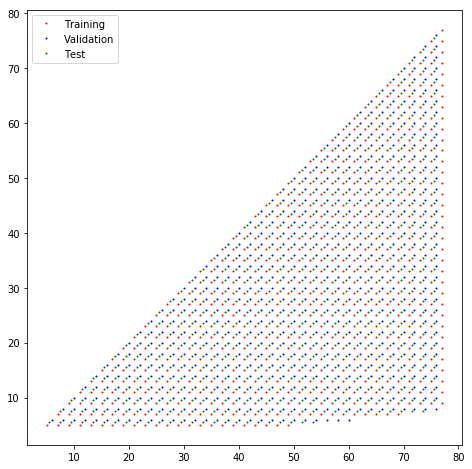

('# of whiten waveform for each set: ', 685)


In [2]:
import h5py as h5
import matplotlib.pyplot as plt
%matplotlib inline

f = h5.File(H5_FILE,'r')

print ("======= HDF Attributes:")
#  1) merger_idx (ignore this) 
#  2) sampling rate 
print (f.attrs.items())

print ("======= HDF arrays:")
print (f.attrs.items())
for i in f.items():
    print (i)
# we have training/validation/test dataset, each set contain two polarization of GW, and also the binary mass
   

####################################################3
m1t = f['train_m1']
m2t = f['train_m2']
m1v = f['val_m1']
m2v = f['val_m2']
m1s = f['test_m1']
m2s = f['test_m2']

plt.figure(figsize=(8,8))
plt.plot(m2t, m1t, 'r.', markersize=2, label="Training")
plt.plot(m2v, m1v, 'b.', markersize=2, label="Validation")
plt.plot(m2s, m1s, 'g.', markersize=2, label="Test")
plt.axes().set_aspect('equal')
plt.legend()
plt.show()

print ("# of whiten waveform for each set: ", len(f['train_hp']))

f.close()

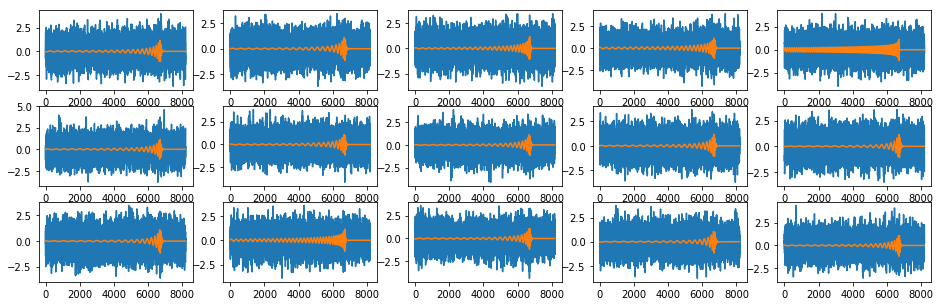

In [3]:
###
###  Prepare data: extract, transform, load (ETL)
###
import h5py as h5
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
    
import os
import time
from datetime import datetime

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

LABLE_WIDTH = 1
RATE = 8192

class GWInject():
    def _shift_noise(self, tag, A, shift):
        var = self.f[tag]
        swf = np.zeros(var.shape)  ## shifted template 
        NX = len(var)
        X = ( np.random.normal(0,1,var.shape)).astype(np.float32)
        MAX=self.srate
        for i in range(NX):
            a = int((np.random.random()-0.5)*shift)  ## shift left or right
            swf[i,max(0,a):min(MAX, MAX+a)] += A * np.roll(var[i], a)[max(0,a):min(MAX, MAX+a)]
            
        X = (A * swf[:NX,:] + np.random.normal(0,1,var.shape)).astype(np.float32)
        Y = np.ones(NX)
        NN = NX
        X  = np.vstack( (X, np.random.normal(0,1,(NX,self.srate))  )         ) .astype(np.float32)
        Y  = np.hstack( (Y, np.zeros(NN) )                          ).astype(np.float32).reshape(-1,1)
        
        if self.plot:
            plt.figure(figsize=(16,5))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)
                plt.plot(X[i,:])
                plt.plot(swf[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.show()

        return X, Y
    def _add_noise(self, tag, A):
        var = self.f[tag]
        NX = len(var)
        X = (A * var[:NX,:] + np.random.normal(0,1,(NX,self.srate))).astype(np.float32)
        #X = (A * var[:NX,:] + (np.random.random((NX,self.srate))-0.5 )*2  ).astype(np.float32)
        Y = np.ones(NX)
        NN = NX
        X  = np.vstack( (X, np.random.normal(0,1,(NX,self.srate))  )         ) .astype(np.float32)
        #X  = np.vstack( (X, (np.random.random((NX,self.srate))-0.5 )*2  )    ) .astype(np.float32)
        Y  = np.hstack( (Y, np.zeros(NN) )                          ).astype(np.float32).reshape(-1,1)
        
        if self.plot:
            plt.figure(figsize=(16,5))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)
                plt.plot(X[i,:])
                plt.plot(A * var[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.show()

        return X, Y
      
    def getdata(self, tag, A):
        var = self.f[tag]
        NX = len(var)
        #X = (A * var[:NX,:] + np.random.normal(0,1,(NX,self.srate))).astype(np.float32)
        X = (A * var[:NX,:] ).astype(np.float32)
        Y = (A * var[:NX,:] ).astype(np.float32)

        return X, Y
      
      
      
    def __init__(self, fname, plot=0):
        self.fname = fname
        self.plot = plot
        self.f = h5.File(fname, "r")
        self.srate = self.f.attrs.get('srate')

    def __exit__(self):
        self.f.close()
        
    def get_train(self, A=1.0):
        X, Y = self.getdata('/train_hp', A)
        return X, Y
    def get_val(self, A=1.0):
        X, Y = self.getdata('/val_hp', A)
        return X, Y
    def get_test(self, A=1.0):
        X, Y = self.getdata('/test_hp', A)
        return X, Y

      
    def get_train_val_set(self, A=1.0):
        X, Y = self._add_noise('/train_hp', A)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=None)
        return X_train, X_val, Y_train, Y_val
    def get_test_set(self, A=1.0):
        return self._add_noise('/test_hp', A)

    def get_shifted_train_val_set(self, A=1.0, shift=0):
        X, Y = self._shift_noise('/train_hp', A, shift)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=None)
        return X_train, X_val, Y_train, Y_val

    def get_shifted_test_set(self, A=1.0, shift=0):
        return self._shift_noise('/test_hp', A, shift)
    
    
tmp = GWInject(H5_FILE, plot=1)
Xt, Xv = tmp.get_shifted_test_set(A=1.0, shift=0)    
tmp.__exit__()

In [ ]:
### See https://www.ycc.idv.tw/tensorflow-tutorial_4.html
import random
class Autoencoder(object):
    def __init__(self,n_features,learning_rate=0.5,n_hidden=[1000,500,250,2],alpha=0.0):
        self.n_features = n_features

        self.weights = None
        self.biases = None

        self.graph = tf.Graph() # initialize new grap
        self.build(n_features,learning_rate,n_hidden,alpha) # building graph
        self.sess = tf.Session(graph=self.graph) # create session by the graph 

    def build(self,n_features,learning_rate,n_hidden,alpha):
        with self.graph.as_default():
            ### Input
            self.train_features = tf.placeholder(tf.float32, shape=(None,n_features))
            self.train_targets  = tf.placeholder(tf.float32, shape=(None,n_features))

            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.y_, self.original_loss, _ = self.structure(
                                               features=self.train_features,
                                               targets=self.train_targets,
                                               n_hidden=n_hidden)
            
            # regularization loss
            # weight elimination L2 regularizer
            #self.regularizer = tf.reduce_sum([tf.reduce_sum(
            #            tf.pow(w,2)/(1+tf.pow(w,2))) for w in self.weights.values()]) \
            #        / tf.reduce_sum(
            #         [tf.size(w,out_type=tf.float32) for w in self.weights.values()])

            # total loss
            self.loss = self.original_loss   #+ alpha * self.regularizer

            # define training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)


            ### Prediction
            self.new_features = tf.placeholder(tf.float32, shape=(None,n_features))
            self.new_targets  = tf.placeholder(tf.float32, shape=(None,n_features))
            self.new_y_, self.new_original_loss, self.new_encoder = self.structure(
                                                          features=self.new_features,
                                                          targets=self.new_targets,
                                                          n_hidden=n_hidden)  
            self.new_loss = self.new_original_loss #+ alpha * self.regularizer

            ### Initialization
            self.init_op = tf.global_variables_initializer()  

    def structure(self,features,targets,n_hidden):

        ### Structure
        activation = tf.nn.relu

        #conv1 = tf.layers.conv2d(features, filters=32, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
        #pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2], strides=2)
        #conv2 = tf.layers.conv2d(pool1, filters=32, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
        #pool2 = tf.layers.max_pooling2d(conv2, pool_size=[2, 2], strides=2)
        #pool2f = tf.reshape(pool2, [-1, 7 * 7 * 64])
        
        n_encoder = [self.n_features] + n_hidden
        encoder = tf.layers.dense(inputs=features, units=n_encoder[1], activation=tf.nn.relu)
        for i in range(2,len(n_hidden)+1):
          print (n_encoder[i])
          encoder = tf.layers.dense(inputs=encoder, units=n_encoder[i], activation=tf.nn.relu)
        
        n_decoder = list(reversed(n_hidden))+[self.n_features]
        decoder = tf.layers.dense(inputs=encoder, units=n_decoder[1], activation=tf.nn.relu)
        for i in range(2,len(n_hidden)+1):
            print (n_decoder[i])
            decoder = tf.layers.dense(inputs=decoder, units=n_decoder[i], activation=tf.nn.relu)

        loss = tf.reduce_mean(tf.pow(targets - decoder, 2))
        
        return (decoder,loss,encoder)


    def fit(self,X,Y,epochs=10,validation_data=None,test_data=None,batch_size=None):
        X = self._check_array(X)
        Y = self._check_array(Y)

        N = X.shape[0]
        random.seed(9000)
        if not batch_size: batch_size=N

        self.sess.run(self.init_op)
        for epoch in range(epochs):
            print("Epoch %2d/%2d: "%(epoch+1,epochs))
            start_time = time.time()

            # mini-batch gradient descent
            index = [i for i in range(N)]
            random.shuffle(index)
            while len(index)>0:
                index_size = len(index)
                batch_index = [index.pop() for _ in range(min(batch_size,index_size))]     

                feed_dict = {self.train_features: X[batch_index,:],
                             self.train_targets: Y[batch_index,:]}
                _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)

                print("[%d/%d] loss = %9.4f     " % ( N-len(index), N, loss ), end='\r')


            # evaluate at the end of this epoch
            msg_valid = ""
            if validation_data is not None:
                val_loss = self.evaluate(validation_data[0],validation_data[1])
                msg_valid = ", val_loss = %9.4f" % ( val_loss )

            train_loss = self.evaluate(X,Y)
            print("[%d/%d] %ds loss = %9.4f %s" % ( N, N, time.time()-start_time,
                                                   train_loss, msg_valid ))

        if test_data is not None:
            test_loss = self.evaluate(test_data[0],test_data[1])
            print("test_loss = %9.4f" % (test_loss))

    def encode(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_encoder, feed_dict={self.new_features: X})

    def predict(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_y_, feed_dict={self.new_features: X})

    def evaluate(self,X,Y):
        X = self._check_array(X)
        return self.sess.run(self.new_loss, feed_dict={self.new_features: X,
                                                       self.new_targets: Y})

    def _check_array(self,ndarray):
        ndarray = np.array(ndarray)
        if len(ndarray.shape)==1: ndarray = np.reshape(ndarray,(1,ndarray.shape[0]))
        return ndarray

In [4]:
####  default
import random

class Autoencoder(object):
    def __init__(self,n_features,learning_rate=0.5,n_hidden=[1024,512,256,2],alpha=0.0):
        self.n_features = n_features

        self.weights = None
        self.biases = None

        self.graph = tf.Graph() # initialize new grap
        self.build(n_features,learning_rate,n_hidden,alpha) # building graph
        self.sess = tf.Session(graph=self.graph) # create session by the graph 

    def build(self,n_features,learning_rate,n_hidden,alpha):
        with self.graph.as_default():
            ### Input
            self.train_features = tf.placeholder(tf.float32, shape=(None,n_features))
            self.train_targets  = tf.placeholder(tf.float32, shape=(None,n_features))

            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.y_, self.original_loss, _ = self.structure(
                                               features=self.train_features,
                                               targets=self.train_targets,
                                               n_hidden=n_hidden)

            # regularization loss
            # weight elimination L2 regularizer
            self.regularizer = tf.reduce_sum([tf.reduce_sum(
                        tf.pow(w,2)/(1+tf.pow(w,2))) for w in self.weights.values()]) \
                    / tf.reduce_sum(
                     [tf.size(w,out_type=tf.float32) for w in self.weights.values()])

            # total loss
            self.loss = self.original_loss + alpha * self.regularizer

            # define training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)

            ### Prediction
            self.new_features = tf.placeholder(tf.float32, shape=(None,n_features))
            self.new_targets  = tf.placeholder(tf.float32, shape=(None,n_features))
            self.new_y_, self.new_original_loss, self.new_encoder = self.structure(
                                                          features=self.new_features,
                                                          targets=self.new_targets,
                                                          n_hidden=n_hidden)  
            self.new_loss = self.new_original_loss + alpha * self.regularizer

            ### Initialization
            self.init_op = tf.global_variables_initializer()  

    def structure(self,features,targets,n_hidden):
        ### Variable
        if (not self.weights) and (not self.biases):
            self.weights = {}
            self.biases = {}

            n_encoder = [self.n_features]+n_hidden
            for i,n in enumerate(n_encoder[:-1]):
                self.weights['encode{}'.format(i+1)] = \
                    tf.Variable(tf.truncated_normal(
                        shape=(n,n_encoder[i+1]),stddev=0.1),dtype=tf.float32)
                self.biases['encode{}'.format(i+1)] = \
                    tf.Variable(tf.zeros( shape=(n_encoder[i+1]) ),dtype=tf.float32)

            n_decoder = list(reversed(n_hidden))+[self.n_features]
            for i,n in enumerate(n_decoder[:-1]):
                self.weights['decode{}'.format(i+1)] = \
                    tf.Variable(tf.truncated_normal(
                        shape=(n,n_decoder[i+1]),stddev=0.1),dtype=tf.float32)
                self.biases['decode{}'.format(i+1)] = \
                    tf.Variable(tf.zeros( shape=(n_decoder[i+1]) ),dtype=tf.float32)                    

        ### Structure
        activation = tf.nn.tanh

        encoder = self.getDenseLayer(features,
                                     self.weights['encode1'],
                                     self.biases['encode1'],
                                     activation=activation)

        for i in range(1,len(n_hidden)-1):
            encoder = self.getDenseLayer(encoder,
                        self.weights['encode{}'.format(i+1)],
                        self.biases['encode{}'.format(i+1)],
                        activation=activation)   

        encoder = self.getDenseLayer(encoder,
                        self.weights['encode{}'.format(len(n_hidden))],
                        self.biases['encode{}'.format(len(n_hidden))]) 

        decoder = self.getDenseLayer(encoder,
                                     self.weights['decode1'],
                                     self.biases['decode1'],
                                     activation=activation)

        for i in range(1,len(n_hidden)-1):
            decoder = self.getDenseLayer(decoder,
                        self.weights['decode{}'.format(i+1)],
                        self.biases['decode{}'.format(i+1)],
                        activation=activation) 

        y_ =  self.getDenseLayer(decoder,
                        self.weights['decode{}'.format(len(n_hidden))],
                        self.biases['decode{}'.format(len(n_hidden))],
                        activation=activation)      

        loss = tf.reduce_mean(tf.pow(targets - y_, 2))

        return (y_,loss,encoder)

    def getDenseLayer(self,input_layer,weight,bias,activation=None):
        x = tf.add(tf.matmul(input_layer,weight),bias)
        if activation:
            x = activation(x)
        return x


    def fit(self,X,Y,epochs=10,validation_data=None,test_data=None,batch_size=None):
        X = self._check_array(X)
        Y = self._check_array(Y)

        N = X.shape[0]
        random.seed(9000)
        if not batch_size: batch_size=N

        self.sess.run(self.init_op)
        for epoch in range(epochs):
            print("Epoch %2d/%2d: "%(epoch+1,epochs))
            start_time = time.time()

            # mini-batch gradient descent
            index = [i for i in range(N)]
            random.shuffle(index)
            while len(index)>0:
                index_size = len(index)
                batch_index = [index.pop() for _ in range(min(batch_size,index_size))]     

                feed_dict = {self.train_features: X[batch_index,:],
                             self.train_targets: Y[batch_index,:]}
                _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)

                print("[%d/%d] loss = %9.4f     " % ( N-len(index), N, loss ), end='\r')


            # evaluate at the end of this epoch
            msg_valid = ""
            if validation_data is not None:
                val_loss = self.evaluate(validation_data[0],validation_data[1])
                msg_valid = ", val_loss = %9.4f" % ( val_loss )

            train_loss = self.evaluate(X,Y)
            print("[%d/%d] %fs loss = %9.4f %s" % ( N, N, time.time()-start_time,
                                                   train_loss, msg_valid ))

        if test_data is not None:
            test_loss = self.evaluate(test_data[0],test_data[1])
            print("test_loss = %9.4f" % (test_loss))

    def encode(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_encoder, feed_dict={self.new_features: X})

    def predict(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_y_, feed_dict={self.new_features: X})

    def evaluate(self,X,Y):
        X = self._check_array(X)
        return self.sess.run(self.new_loss, feed_dict={self.new_features: X,
                                                       self.new_targets: Y})

    def _check_array(self,ndarray):
        ndarray = np.array(ndarray)
        if len(ndarray.shape)==1: ndarray = np.reshape(ndarray,(1,ndarray.shape[0]))
        return ndarray

In [5]:
RATE=8192
model_1 = Autoencoder( n_features = RATE,
                       learning_rate = 0.005,
                       n_hidden=[2048, 1024, 512, 256, 128],
                       alpha=0.001
                     )

GWD = GWInject(H5_FILE, plot=1)
Xt, Yt = GWD.get_train(A=1.0)
Xv, Yv = GWD.get_val(A=1.0)
Xs, Ys = GWD.get_test(A=1.0)

print((Xt.shape))
print((Xv.shape))
print((Xs.shape))

model_1.fit(X=Xt, Y=Yt,
           epochs=20,
           validation_data=(Xv, Yv),
           test_data=(Xs, Ys),
           batch_size = 16
          )



(685, 8192)
(658, 8192)
(654, 8192)
Epoch  1/20: 
[685/685] 11s loss =    0.9785 , val_loss =    0.9788
Epoch  2/20: 
[685/685] 7s loss =    1.0011 , val_loss =    1.0000
Epoch  3/20: 
[685/685] 7s loss =    1.0051 , val_loss =    1.0055
Epoch  4/20: 
[685/685] 7s loss =    1.0201 , val_loss =    1.0200
Epoch  5/20: 
[685/685] 7s loss =    1.0211 , val_loss =    1.0210
Epoch  6/20: 
[685/685] 7s loss =    1.0216 , val_loss =    1.0216
Epoch  7/20: 
[685/685] 7s loss =    1.0143 , val_loss =    1.0140
Epoch  8/20: 
[685/685] 7s loss =    1.0061 , val_loss =    1.0058
Epoch  9/20: 
[685/685] 7s loss =    0.9777 , val_loss =    0.9776
Epoch 10/20: 
[685/685] 7s loss =    1.0094 , val_loss =    1.0087
Epoch 11/20: 
[685/685] 7s loss =    1.0079 , val_loss =    1.0076
Epoch 12/20: 
[685/685] 7s loss =    0.9993 , val_loss =    0.9989
Epoch 13/20: 
[685/685] 7s loss =    1.0022 , val_loss =    1.0015
Epoch 14/20: 
[685/685] 7s loss =    1.0117 , val_loss =    1.0116
Epoch 15/20: 
[685/685] 7

[4.2881578e-02 4.2385370e-02 4.1880608e-02 ... 4.8620062e-05 4.9536084e-05
 5.0449256e-05]
[[-1.         -0.90387166  1.         ... -1.         -1.
   1.        ]]
1.1483039 -1.1400057
1.0000001 -1.0000001


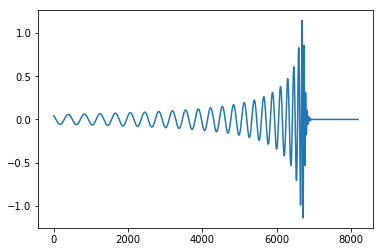

In [6]:
for i in range(0,1):
    plt.figure()
    w0 = Xt[i]
    w1 = model_1.predict(w0)
    print (w0)
    print (w1)
    print (w0.max(),w0.min())
    print (w1.max(),w1.min())
    plt.plot(w0)
    plt.plot(w1)
    plt.show()
    

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(Ys[10])
plt.plot(Xs[10])
plt.show()